# Setup

In [1]:
# %pip install numpy
# %pip install scipy
# %pip install pandas
# %pip install seaborn
# %pip install matplotlib
# %pip install "tensorflow[and-cuda]"
# %pip install tensorflow_io
# %pip install tensorflow_datasets
# %pip install sounddevice

## Importy

In [2]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
import sounddevice as sd

2024-06-04 04:47:43.062675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 04:47:44.643717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Pobranie i załadowanie dataset'u

https://www.tensorflow.org/datasets/catalog/speech_commands

In [3]:
# stosunek danych do użycia z datasetu
frac = 1.0

split = [
    f"train[:{frac:.0%}]",
    f"validation[:{frac:.0%}]",
    f"test[:{frac:.0%}]"
]

datasets, info = tfds.load("speech_commands", 
                           split=split,
                           with_info=True,
                           as_supervised=True)
train_ds, val_ds, test_ds = datasets

2024-06-04 04:47:46.309482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 04:47:46.358369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 04:47:46.358689: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Możliwe klasy

In [4]:
label_names = info.features["label"].names
print(*label_names, sep="\n", end="\n\n")
print("liczba klas: {}".format(info.features["label"].num_classes))

down
go
left
no
off
on
right
stop
up
yes
_silence_
_unknown_

liczba klas: 12


### Rozłożenie klas

In [5]:
train_labels = [y.numpy() for X, y in train_ds]
val_labels = [y.numpy() for X, y in val_ds]
test_labels = [y.numpy() for X, y in test_ds]

2024-06-04 04:48:16.693839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-04 04:48:20.507897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-04 04:48:22.361405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


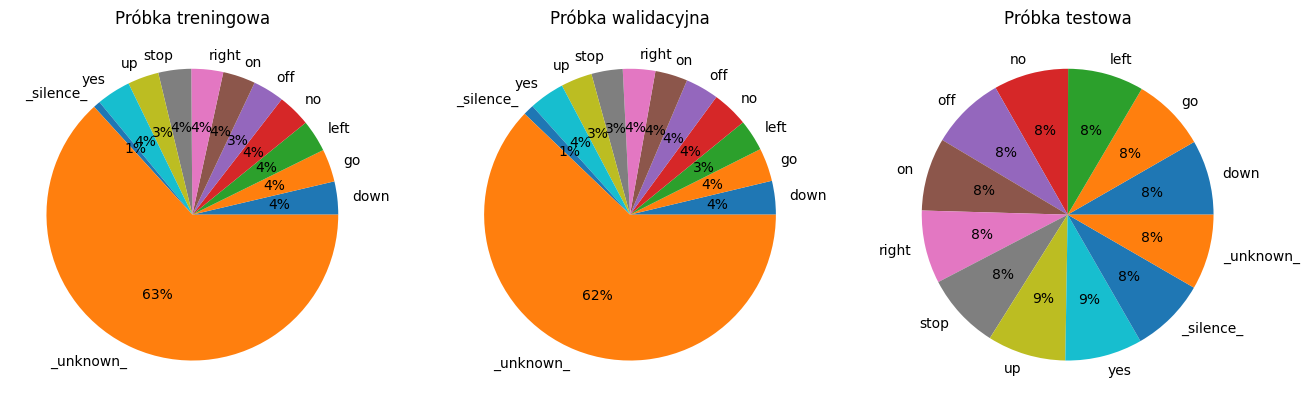

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(16, 10))

unique, counts = np.unique(train_labels, return_counts=True)
unique = [label_names[y] for y in unique]
axs[0].pie(counts, labels=unique, autopct="%.0f%%")
axs[0].set_title("Próbka treningowa")

unique, counts = np.unique(val_labels, return_counts=True)
unique = [label_names[y] for y in unique]
axs[1].pie(counts, labels=unique, autopct="%.0f%%")
axs[1].set_title("Próbka walidacyjna")

unique, counts = np.unique(test_labels, return_counts=True)
unique = [label_names[y] for y in unique]
axs[2].pie(counts, labels=unique, autopct="%.0f%%")
axs[2].set_title("Próbka testowa")

plt.show()

### Przykładowe dane - klipy

In [7]:
tfds.as_dataframe(train_ds.take(9), info)

2024-06-04 04:48:23.280731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


audio  label
0  [-15, -18, -12, -21, -22, -13, -21, -22, -13, ...      4
1  [75, 29, -85, 5, 68, -13, -61, 18, 60, -48, -3...      5
2  [0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, ...      7
3  [1, 15, 13, 11, 2, -19, -19, -11, -5, 14, 27, ...      5
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      7
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      2
6  [45, 82, 40, 9, -15, -52, -82, -100, -102, -10...     11
7  [29, 87, 151, 212, 279, 334, 319, 265, 187, 10...      7
8  [-12, -15, -20, -22, -25, -25, -32, -30, -39, ...      6

### Przykładowe dane - wykresy

2024-06-04 04:48:23.930291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


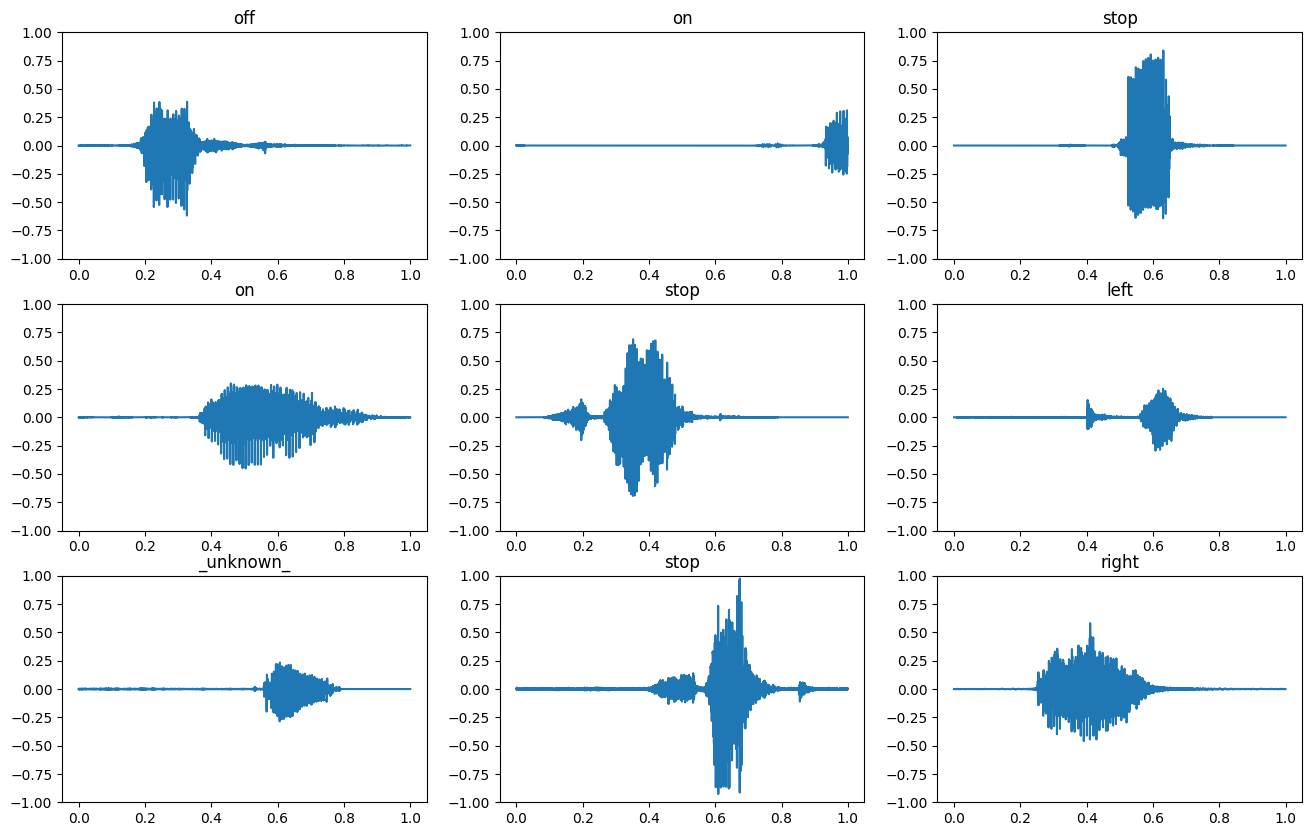

In [8]:
rows = 3
cols = 3
n = rows * cols
fig, axs = plt.subplots(rows, cols, figsize=(16, 10))
for k, (audio, label) in enumerate(train_ds.take(n)):
    i, j = divmod(k, cols)
    ts = np.linspace(0, 1, 16000)
    audio = (audio / np.iinfo(np.int16).max).numpy()
    audio = np.pad(audio, [[0, 16000 - len(audio)]])
    axs[i, j].plot(ts, audio)
    axs[i, j].set_title(info.features["label"].names[label])
    axs[i, j].set_ylim(-1, 1)
plt.show()

# Preprocessing

## Spektrogram w skali Mela

In [9]:
fft_length=256
sequence_stride=128
sequence_length=None
window='hann'
sampling_rate=16000
num_mel_bins=64
min_freq=20.0
max_freq=None
power_to_db=True
top_db=80.0
mag_exp=2.0
min_power=1e-10
ref_power=1.0

mel_spectrogram_layer = layers.MelSpectrogram(
    fft_length=fft_length,
    sequence_stride=sequence_stride,
    sequence_length=sequence_length,
    window=window,
    sampling_rate=sampling_rate,
    num_mel_bins=num_mel_bins,
    min_freq=min_freq,
    max_freq=max_freq,
    power_to_db=power_to_db,
    top_db=top_db,
    mag_exp=mag_exp,
    min_power=min_power,
    ref_power=ref_power,
)

## Datasety spektrogramów

In [10]:
def get_spectrogram(audio):
    min_size = 16000 - tf.shape(audio)[0]
    paddings = [[0, min_size]]
    padded_scaled_audio = tf.pad(
        tf.cast(audio / np.iinfo(np.int16).max, tf.float32),
        paddings=paddings,
        mode="CONSTANT"
    )
    return tf.transpose(mel_spectrogram_layer(padded_scaled_audio))

train_spectrogram_ds = train_ds.map(
    lambda X, y: (get_spectrogram(X), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_spectrogram_ds = val_ds.map(
    lambda X, y: (get_spectrogram(X), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_spectrogram_ds = test_ds.map(
    lambda X, y: (get_spectrogram(X), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

### Przykładowe dane - spektrogramy

2024-06-04 04:48:27.583876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


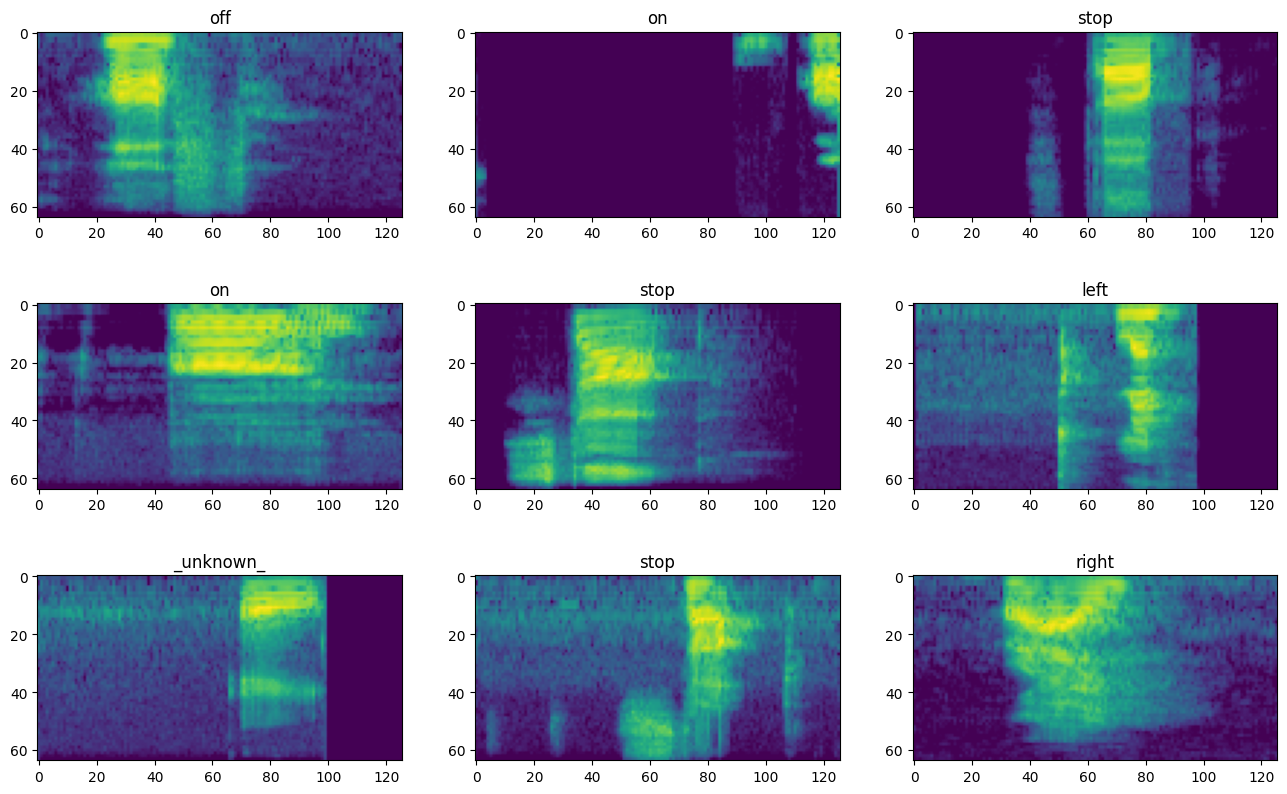

In [11]:
rows = 3
cols = 3
n = rows * cols

rows = 3
cols = 3
n = rows * cols
fig, axs = plt.subplots(rows, cols, figsize=(16, 10))
for k, (spectrogram, label) in enumerate(train_spectrogram_ds.take(n)):
        i, j = divmod(k, cols)
        axs[i, j].imshow(spectrogram.numpy().T)
        axs[i, j].set_title(info.features["label"].names[label])
plt.show()

### Optymalizacja

In [12]:
batch_size=32

train_spectrogram_ds = train_spectrogram_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_spectrogram_ds = val_spectrogram_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_spectrogram_ds = test_spectrogram_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

## Normalizacja

In [13]:
normalization_layer = layers.Normalization(name="normalization")
normalization_layer.adapt(
    data=train_spectrogram_ds.map(lambda X, y: X)
)

2024-06-04 04:49:02.859245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Przykładowe dane - znormalizowane spektrogramy

2024-06-04 04:49:03.978488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


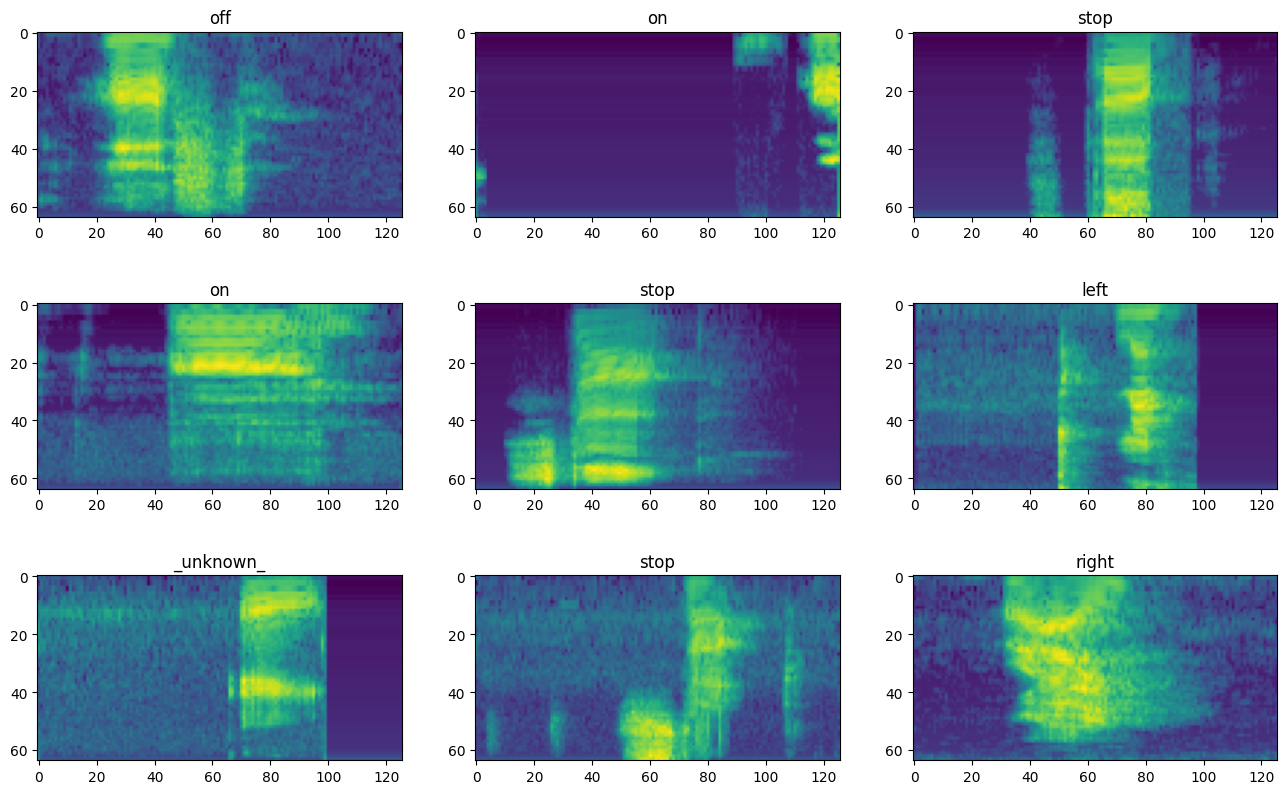

In [14]:
rows = 3
cols = 3
n = rows * cols

fig, axs = plt.subplots(rows, cols, figsize=(16, 10))
for Xs, ys in train_spectrogram_ds.take(1):
    for k, (spectrogram, label) in enumerate(zip(Xs[:n], ys[:n])):
        i, j = divmod(k, cols)
        axs[i, j].imshow(normalization_layer(spectrogram).numpy().T)
        axs[i, j].set_title(info.features["label"].names[label])
plt.show()

# Model

## Przepis modelu

In [15]:
def build_model(input_dim,
                output_dim,
                filters,
                kernel_size,
                strides,
                dense_units,
                name):
    input_spectrogram = keras.Input((16000 // sequence_stride + 1, input_dim), name="input")
    x = normalization_layer(input_spectrogram)
    x = layers.Reshape((-1, input_dim, 1), name="reshape")(x)
    for i, (filters_, kernel_size_, strides_) in enumerate(zip(filters, kernel_size, strides, strict=True)):
        x = layers.Conv2D(
            filters=filters_,
            kernel_size=kernel_size_,
            strides=strides_,
            padding="same",
            use_bias=False,
            name=f"conv_{i+1}"
        )(x)
        x = layers.BatchNormalization(name=f"conv_{i+1}_bn")(x)
        x = layers.ReLU(name=f"conv_{i+1}_relu")(x)
    x = layers.MaxPool2D(name="max_pool")(x)
    x = layers.Flatten(name="flatten")(x)
    for i, dense_units_ in enumerate(dense_units):
        x = layers.Dropout(0.5, name=f"droupout_{i+1}")(x)
        x = layers.Dense(dense_units_, name=f"dense_{i+1}")(x)
        x = layers.BatchNormalization(name=f"dense_{i+1}_bn")(x)
        x = layers.ReLU(name=f"dense_{i+1}_relu")(x)
    x = layers.Dropout(0.5, name=f"droupout_{i+2}")(x)
    x = layers.Dense(output_dim, name="output_dense")(x)
    output = layers.Softmax(name="output_dense_softmax")(x)
    model = keras.Model(input_spectrogram, output, name=name)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

## Hiperparametry

In [16]:
filters = [
    32,
    32,
    32,
]

kernel_size = [
    [11, 41],
    [11, 21],
    [11, 21],
]

strides = [
    [2, 2],
    [1, 2],
    [1, 2],
]

dense_units = [
    128,
]

## Budowa modelu

In [17]:
training_model = build_model(num_mel_bins,
                             info.features["label"].num_classes,
                             filters,
                             kernel_size,
                             strides,
                             dense_units,
                             name="training_model")

## Callbacki

In [18]:
early_stopping = keras.callbacks.EarlyStopping(
    start_from_epoch=10
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="./training_model.keras",
    save_best_only=True
)

csv_logger = keras.callbacks.CSVLogger("history.log")

reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau()

callbacks = [
    early_stopping,
    model_checkpoint,
    csv_logger,
    reduce_lr_on_plateau
]

## Trening

In [19]:
epochs = 100

history = training_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1717469349.650879  111558 service.cc:145] XLA service 0x57a38b5ccc60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717469349.651077  111558 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-06-04 04:49:09.794526: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-04 04:49:10.421738: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   7/2673 ━━━━━━━━━━━━━━━━━━━━ 1:12 27ms/step - accuracy: 0.0585 - loss: 3.5759

I0000 00:00:1717469358.659370  111558 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2673/2673 ━━━━━━━━━━━━━━━━━━━━ 82s 26ms/step - accuracy: 0.6542 - loss: 1.2149 - val_accuracy: 0.8308 - val_loss: 0.4899 - learning_rate: 0.0010
Epoch 2/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.8764 - loss: 0.3865 - val_accuracy: 0.9190 - val_loss: 0.2492 - learning_rate: 0.0010
Epoch 3/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.9146 - loss: 0.2728 - val_accuracy: 0.9383 - val_loss: 0.1992 - learning_rate: 0.0010
Epoch 4/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 62s 23ms/step - accuracy: 0.9321 - loss: 0.2187 - val_accuracy: 0.9538 - val_loss: 0.1651 - learning_rate: 0.0010
Epoch 5/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.9416 - loss: 0.1866 - val_accuracy: 0.9609 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 6/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.9490 - loss: 0.1668 - val_accuracy: 0.9588 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 7/100
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 62s 23ms/step - accuracy: 0

# Ewaluacja

## Przebieg uczenia

In [20]:
try:
    history_df = pd.DataFrame(history.history)
except NameError:
    history_df = pf.read_csv("./history.log")

<Axes: title={'center': 'Przebieg uczenia'}>

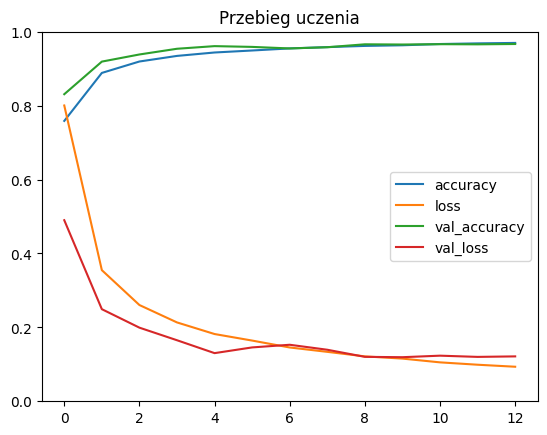

In [21]:
history_df[["accuracy", "loss", "val_accuracy", "val_loss"]].plot(title="Przebieg uczenia", ylim=(0, 1))

## Wynik na zbiorze testowym

In [22]:
loss, acc = training_model.evaluate(test_spectrogram_ds)
print(f"Accuracy: {acc}")
print(f"Loss: {loss}")

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9487 - loss: 0.1757
Accuracy: 0.9474437832832336
Loss: 0.1946088671684265


### Confusion Matrix

2024-06-04 05:03:02.952755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


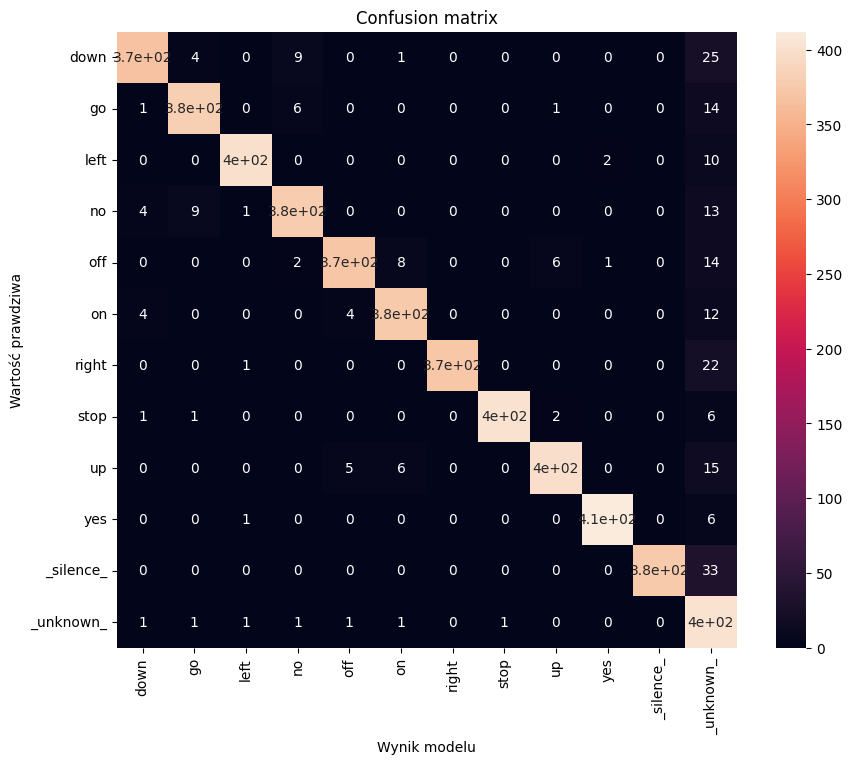

In [23]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda X, y: y)), axis=0)

y_pred = training_model.predict(test_spectrogram_ds)
y_pred = np.argmax(y_pred, axis=-1)

confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True)
plt.xlabel("Wynik modelu")
plt.ylabel("Wartość prawdziwa")
plt.title("Confusion matrix")
plt.show()

# Interaktywny test

### Wczytanie modelu

In [24]:
try:
    training_model
except NameError:
    training_model = tf.keras.models.load_model("./training_model.keras")

def predict(audio):
    audio = tf.conver_to_tensor(audio)
    single_value = audio.ndim == 1
    if single_value:
        audio = tf.expand_dims(audio, axis=0)
    spectrogram = get_spectrogram(audio)
    y_pred = training_model(spectrogram, training=False)
    y_pred = tf.math.argmax(y_pred, axis=-1)
    

In [25]:
import sounddevice as sd
import time

Zaczynam nagrywać za 0 s
Nagrywanie!
Koniec!


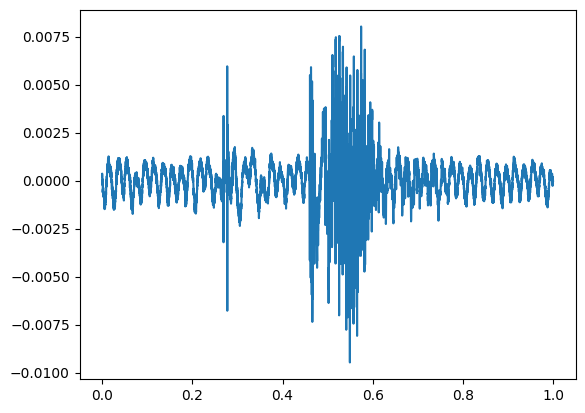

Nagrane audio:


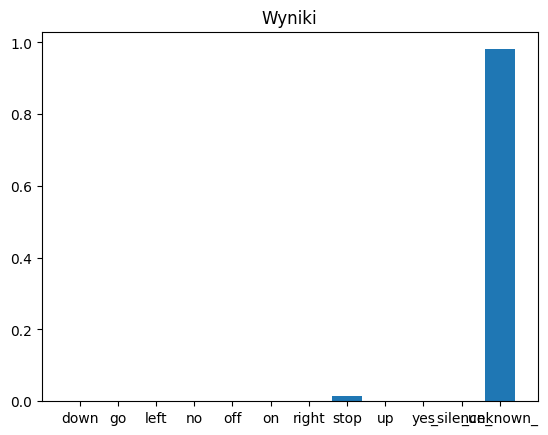

In [29]:
countdown = 3
duration = 1

for i in range(countdown):
    print(f"Zaczynam nagrywać za {countdown - i} s", end='\r')
    time.sleep(1)

print("Zaczynam nagrywać za 0 s")
print("Nagrywanie!")
audio = sd.rec(int(duration * sampling_rate),
               samplerate=sampling_rate,
               channels=1,
               dtype="float32",
               blocking=True)
print("Koniec!")
audio = np.squeeze(audio, axis=1)

plt.plot(np.linspace(0, 1, 16000), audio)
plt.show()

print("Nagrane audio:")
display.display(display.Audio(audio, rate=sampling_rate))

spectrogram = get_spectrogram(audio)[tf.newaxis]
y_pred = training_model(spectrogram, training=False)
y_pred = tf.squeeze(y_pred, axis=0)

plt.bar(label_names, y_pred)
plt.title("Wyniki")
plt.show()

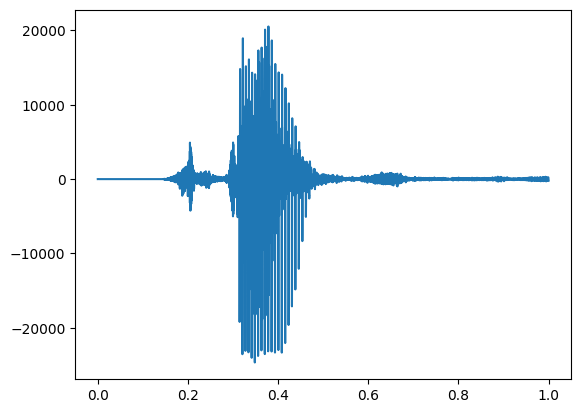

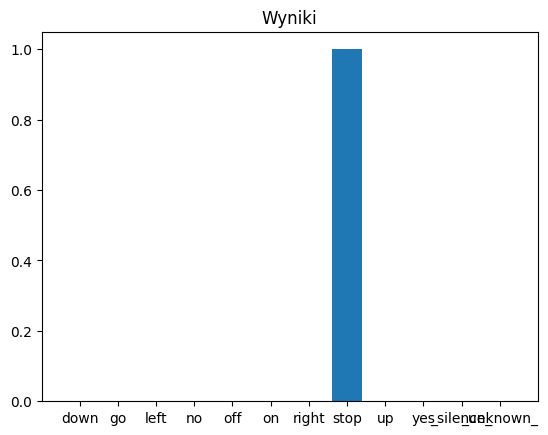

2024-06-04 05:08:36.928979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
for (audio, label) in test_ds.take(1):
    plt.plot(np.linspace(0, 1, 16000), audio)
    plt.show()
    display.display(display.Audio(audio, rate=sampling_rate))
    spectrogram = get_spectrogram(audio)[tf.newaxis]
    y_pred = training_model(spectrogram, training=False)
    y_pred = tf.squeeze(y_pred, axis=0)
    plt.bar(label_names, y_pred)
    plt.title("Wyniki")
    plt.show()